Training period: 1995-10-01 00:00:00+00:00 to 2018-04-20 00:00:00+00:00
Validation period: 2019-01-01 00:00:00+00:00 to 2025-06-01 00:00:00+00:00
Training samples: 8216 (77.8%)
Validation samples: 2344 (22.2%)
Gap between training and validation: 2019-01-01 - 2018-04-21
New sequence shapes:
X_train shape: (8203, 7, 1)
y_train shape: (8203, 7)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 128)    │     66,560 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 128),     │    131,584 │ lstm_36[0][0]     │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 7, 128)    │          0 │ lstm_37[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 7, 128)    │    131,584 │ repeat_vector_9[… │
│                     │                   │            │ lstm_37[0][1],    │
│                     │                   │            │ lstm_37[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 7, 128)    │    131,584 │ lstm_38[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 7, 1)      │        129 │ lstm_39[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.9273 - val_loss: 0.8093
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.6840 - val_loss: 0.7426
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.6359 - val_loss: 0.7329
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.6431 - val_loss: 0.7186
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.6441 - val_loss: 0.7161
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.6291 - val_loss: 0.7038
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.6187 - val_loss: 0.6959
Epoch 8/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.6116 - val_loss: 0.6961
Epoch 9/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.6157 - val_loss: 0.6802
Epoch 10/150
65/65 ━━━━━━━━━━━━━━━━━━━━ -0s -7771us/step - loss: 0.5843 - val_loss: 0.6811
Epoch 11/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.5844 - val_loss: 0.6709
Epoch 12/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/

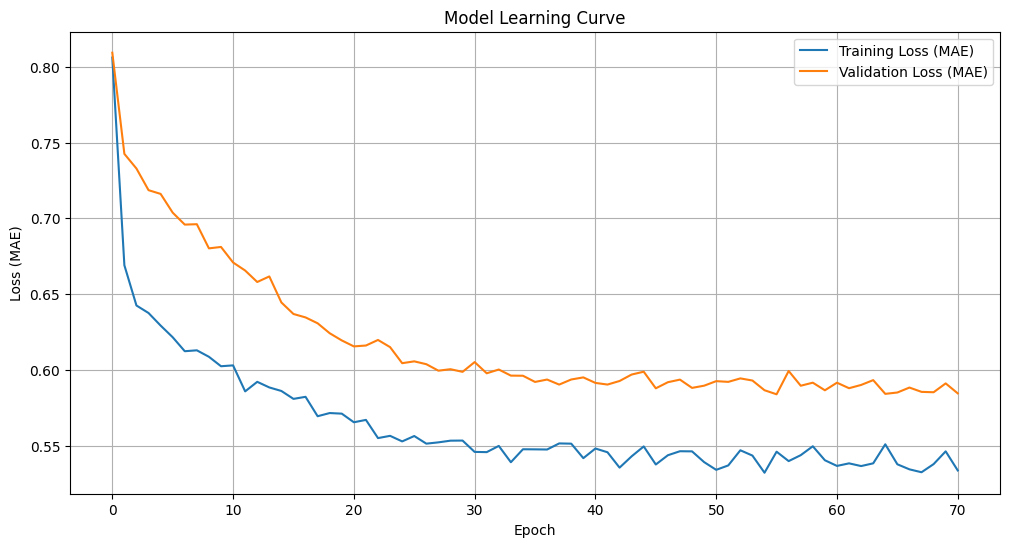

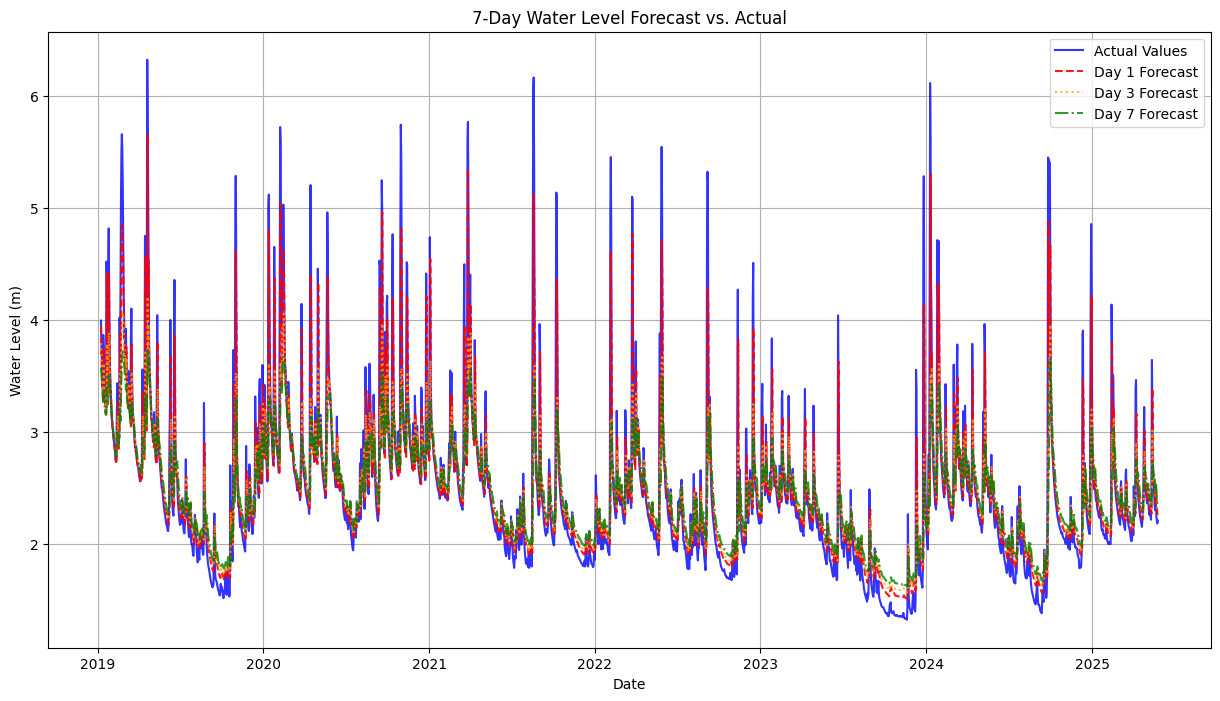

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

# 1. Load and Prepare Data
df = pd.read_csv('dataset.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df_univariate = df[['stage_m']].copy()
df_univariate.interpolate(method='linear', inplace=True)

# 2. Split Data with a Gap (following paper methodology)
# Dataset: 1995-10-01 to 2025-06-01 (~29.67 years)
# Paper approach: 76% training, 23% validation with gap
# Training: 76% of 29.67 years ≈ 22.55 years → 1995-10-01 to 2018-04-21
# Gap: ~8 months (2018-04-21 to 2019-01-01)
# Validation: 2019-01-01 to 2025-06-01
split_date_train_end = '2018-04-21'
split_date_val_start = '2019-01-01'
train_data = df_univariate.loc[df_univariate.index < split_date_train_end]
val_data = df_univariate.loc[df_univariate.index >= split_date_val_start]

print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Validation period: {val_data.index.min()} to {val_data.index.max()}")
print(f"Training samples: {len(train_data)} ({len(train_data)/(len(train_data)+len(val_data))*100:.1f}%)")
print(f"Validation samples: {len(val_data)} ({len(val_data)/(len(train_data)+len(val_data))*100:.1f}%)")
print(f"Gap between training and validation: {split_date_val_start} - {split_date_train_end}")

# 3. Scale Data and Save Scaler with joblib
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

# Save the scaler using joblib
joblib.dump(scaler, 'univariate_scaler.joblib')

# 4. Create Sequences
N_PAST = 7   # Use 7 days of history
N_FUTURE = 7  # Predict 7 days into the future

def create_sequences(data, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, 0])
        y.append(data[i:i + n_future, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train_data, N_PAST, N_FUTURE)
X_val, y_val = create_sequences(scaled_val_data, N_PAST, N_FUTURE)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

print(f"New sequence shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# 5. Build Stacked LSTM Encoder-Decoder
n_features = X_train.shape[2]
UNITS = 128
DROPOUT_RATE = 0.15

# --- Encoder ---
inputs = Input(shape=(N_PAST, n_features))
# Layer 1
encoder_l1 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(inputs)
# Layer 2
encoder_l2, state_h, state_c = LSTM(UNITS, return_sequences=False, dropout=DROPOUT_RATE, return_state=True)(encoder_l1)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_inputs = RepeatVector(N_FUTURE)(encoder_l2)
# Layer 1
decoder_l1 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(decoder_inputs, initial_state=encoder_states)
# Layer 2
decoder_l2 = LSTM(UNITS, return_sequences=True, dropout=DROPOUT_RATE)(decoder_l1)
# Output Layer
output = TimeDistributed(Dense(1))(decoder_l2)

model = Model(inputs=inputs, outputs=output)

# 6. Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# 7. Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_univariate_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# 8. Evaluation and Visualization
best_model = tf.keras.models.load_model('best_univariate_model.keras')
# Load the scaler using joblib
loaded_scaler = joblib.load('univariate_scaler.joblib')

predictions_scaled = best_model.predict(X_val).squeeze()
predictions_original = loaded_scaler.inverse_transform(predictions_scaled)
y_true_original = loaded_scaler.inverse_transform(y_val)

print("\n--- Model Performance on Validation Set ---")
for i in range(N_FUTURE):
    day = i + 1
    mae = mean_absolute_error(y_true_original[:, i], predictions_original[:, i])
    rmse = np.sqrt(mean_squared_error(y_true_original[:, i], predictions_original[:, i]))
    r2 = r2_score(y_true_original[:, i], predictions_original[:, i])
    print(f"Day {day} Ahead -> MAE: {mae:.4f} m, RMSE: {rmse:.4f} m, R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss (MAE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
plt.title('Model Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.show()

val_dates = val_data.index[N_PAST:len(y_true_original) + N_PAST]
plt.figure(figsize=(15, 8))
plt.plot(val_dates, y_true_original[:, 0], label='Actual Values', color='blue', alpha=0.8)
plt.plot(val_dates, predictions_original[:, 0], label='Day 1 Forecast', color='red', linestyle='--', alpha=0.9)
plt.plot(val_dates, predictions_original[:, 2], label='Day 3 Forecast', color='orange', linestyle=':', alpha=0.8)
plt.plot(val_dates, predictions_original[:, 6], label='Day 7 Forecast', color='green', linestyle='-.', alpha=0.8)
plt.title('7-Day Water Level Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.legend()
plt.grid(True)
plt.show()